In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/Volumes/Carlos Vallejo SSD/Triple Ten/tripleten-ds/ttds_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils

In [ ]:
def aplicar_pca_tsne(df: pd.DataFrame, columna_excluir: str, escalado: bool = False):
    """
    Aplica PCA y t-SNE a un DataFrame, excluyendo una columna específica.

    Parámetros:
    - df: DataFrame original.
    - columna_excluir: Nombre de la columna que se excluirá de la reducción de dimensionalidad.
    - escalado: Booleano que indica si los datos ya están escalados. Si False, se escalan.

    Retorna:
    - df_pca: DataFrame con columnas ['PCA1', 'PCA2', columna_excluir].
    - df_tsne: DataFrame con columnas ['TSNE1', 'TSNE2', columna_excluir].
    """
    if columna_excluir not in df.columns:
        raise ValueError(f"La columna '{columna_excluir}' no existe en el DataFrame.")

    # Separar la columna a excluir
    datos = df.drop(columns=[columna_excluir])
    etiqueta = df[columna_excluir]

    # Escalar si es necesario
    if not escalado:
        scaler = StandardScaler()
        datos = scaler.fit_transform(datos)
    else:
        datos = datos.values  # Convertir a array si ya está escalado

    # PCA
    pca = PCA(n_components=2)
    datos_pca = pca.fit_transform(datos)
    df_pca = pd.DataFrame(datos_pca, columns=['PCA1', 'PCA2'])
    df_pca[columna_excluir] = etiqueta.values

    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    datos_tsne = tsne.fit_transform(datos)
    df_tsne = pd.DataFrame(datos_tsne, columns=['TSNE1', 'TSNE2'])
    df_tsne[columna_excluir] = etiqueta.values

    return df_pca, df_tsne


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualizar_clusters(df: pd.DataFrame, columna_x: str, columna_y: str, columna_hue: str):
    """
    Visualiza clusters en un scatterplot usando seaborn.

    Parámetros:
    - df: DataFrame que contiene los datos.
    - columna_x: Nombre de la columna para el eje X.
    - columna_y: Nombre de la columna para el eje Y.
    - columna_hue: Nombre de la columna que representa los clusters (hue).
    """
    if not all(col in df.columns for col in [columna_x, columna_y, columna_hue]):
        raise ValueError("Una o más columnas no existen en el DataFrame.")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df,
        x=columna_x,
        y=columna_y,
        hue=columna_hue,
        palette='tab10'
    )
    plt.title('Clusters de Clientes (KMeans)')
    plt.xlabel(columna_x)
    plt.ylabel(columna_y)
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.show()

# 🛍️ Segmentación de Clientes con Clustering

## 📘 Contexto del ejercicio

El siguiente ejercicio se basa en un conjunto de datos recopilado por un centro comercial (mall) para entender mejor a sus clientes. El dataset contiene información básica de cada cliente, como su edad, género, nivel de ingresos anuales y una puntuación de gasto.

La variable **Spending Score (1-100)** fue asignada por el mall, y representa una estimación del comportamiento de compra del cliente: un valor alto indica que el cliente gasta mucho y frecuentemente, mientras que un valor bajo sugiere poca actividad de compra.

Esta información es clave para **segmentar clientes en grupos con características similares**, lo que permite diseñar campañas de marketing más efectivas y personalizadas.

El dataset incluye las siguientes columnas:

- `CustomerID`: Identificador único del cliente.
- `Gender`: Sexo del cliente (Male / Female).
- `Age`: Edad en años.
- `Annual Income (k$)`: Ingreso anual en miles de dólares.
- `Spending Score (1-100)`: Puntuación de gasto estimada por el mall.

---

## 🎯 Objetivo del ejercicio

El propósito del ejercicio es que apliques técnicas de **clustering no supervisado** para segmentar a los clientes del mall en grupos con comportamientos similares. No solo se espera que implementes un algoritmo, sino que tomes decisiones fundamentadas, analices críticamente los resultados y discutas las implicaciones de cada paso.

---

## 🧩 Enunciado del ejercicio

1. **Carga y analiza los datos**:
   - Explora la distribución de las variables y detecta posibles outliers.
   - Visualiza la relación entre ingreso y score de gasto.
   - Codifica las variables categóricas si es necesario.

2. **Prepara los datos para clustering**:
   - Decide qué variables son relevantes para la segmentación.
   - Aplica escalado si es necesario (`StandardScaler`, `MinMaxScaler`, etc.).

3. **Aplica al menos dos técnicas de clustering**:
   - Por ejemplo, KMeans y Clustering Jerárquico.
   - Determina el número óptimo de clusters usando métodos como Elbow o Silhouette Score.

4. **Evalúa e interpreta los resultados**:
   - Visualiza los clusters resultantes.
   - Describe las características de cada grupo.
   - Propón una estrategia de marketing o acción para cada segmento.

5. **Reflexiona**:
   - ¿Qué tan útiles son los clusters encontrados?
   - ¿Qué decisiones influyeron más en los resultados?
   - ¿Cómo mejorarías este análisis si tuvieras más datos?

> 💡 Recuerda: tu objetivo no es obtener la "respuesta correcta", sino demostrar tu capacidad para **razonar, justificar tus decisiones y comunicar tus hallazgos** de forma clara.


## Carga de datos

In [8]:
# Download latest version
path = kagglehub.dataset_download("shwetabh123/mall-customers")

df = pd.read_csv(f'{path}/Mall_Customers.csv')

100%|██████████| 1.56k/1.56k [00:00<00:00, 1.24MB/s]

Extracting files...


In [9]:
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


# Solucion

## EDA

In [ ]:
# Paso 3: Exploración inicial
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


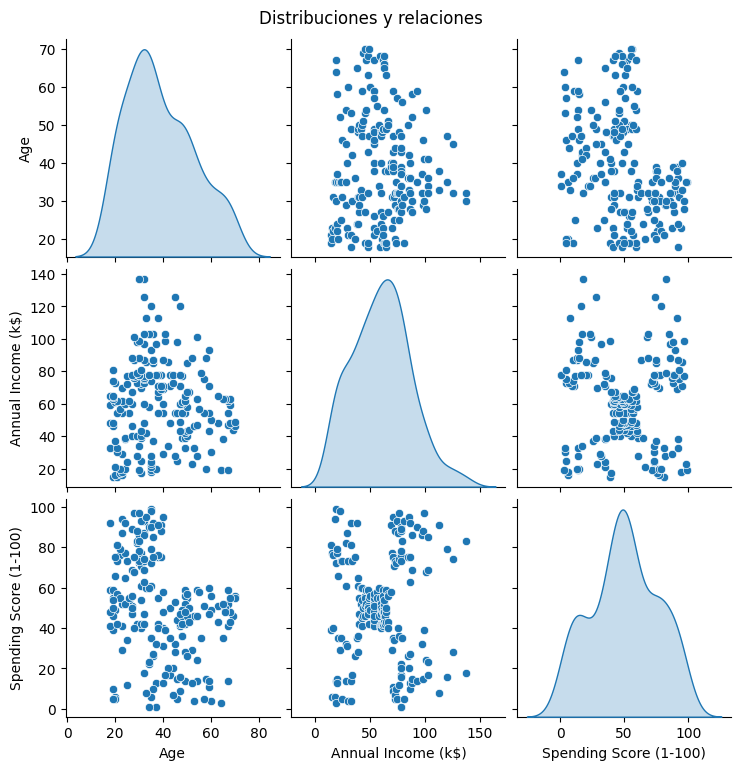

In [ ]:
# Paso 4: Visualización inicial
sns.pairplot(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']], diag_kind="kde")
plt.suptitle("Distribuciones y relaciones", y=1.02)
plt.show()

## Preprocesamiento

In [ ]:
# Paso 5: Preprocesamiento
# Codificar variable categórica
df_encoded = df.copy()
df_encoded['Genre'] = df_encoded['Genre'].map({'Male': 0, 'Female': 1})

In [ ]:
# Seleccionar variables relevantes
X = df_encoded[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

In [ ]:
# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Selección de numero de clusters optimo

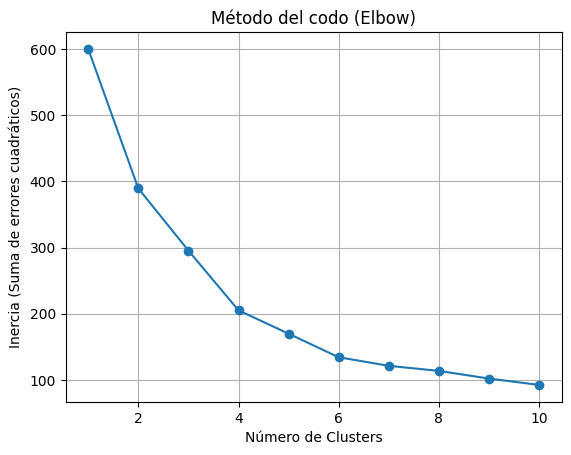

In [ ]:
# Paso 6: Determinar número óptimo de clusters con Elbow Method
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.title('Método del codo (Elbow)')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia (Suma de errores cuadráticos)')
plt.grid(True)
plt.show()

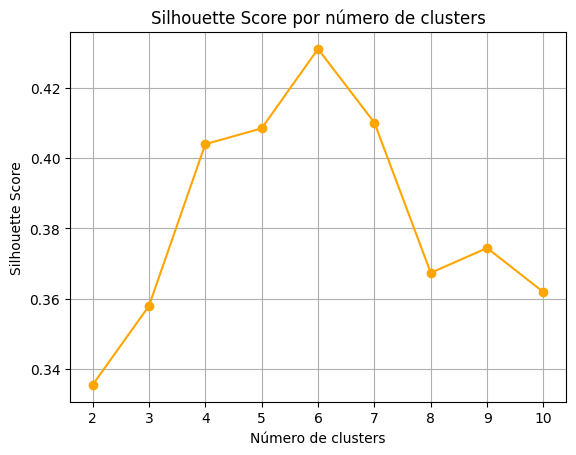

In [ ]:
# Paso 7: Evaluación con Silhouette Score para k = 2 a 10
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)

plt.plot(range(2, 11), sil_scores, marker='o', color='orange')
plt.title("Silhouette Score por número de clusters")
plt.xlabel("Número de clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

## Kmeans

In [ ]:
# Elegimos k = 5 por ejemplo
k_optimo = 6
kmeans = KMeans(n_clusters=k_optimo, random_state=42)
df_encoded['Cluster_KMeans'] = kmeans.fit_predict(X_scaled)

In [ ]:
pca_kmeans, tsne_kmeans = aplicar_pca_tsne(df_encoded, 'Cluster_KMeans', True)

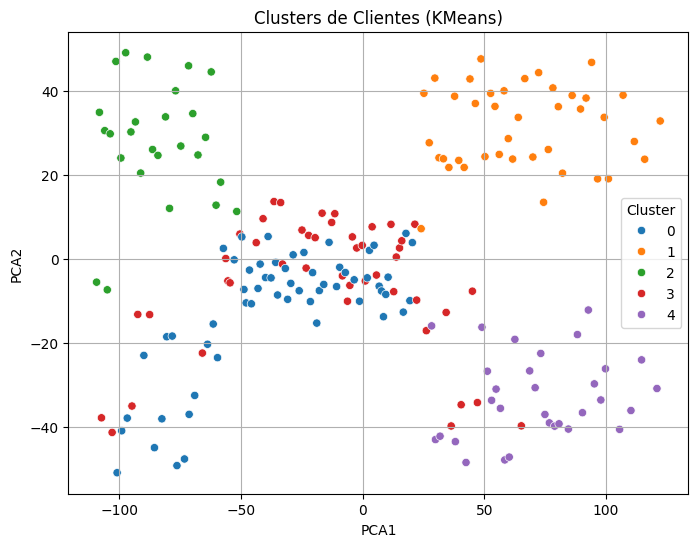

In [ ]:
visualizar_clusters(
    df=pca_kmeans,
    columna_x='PCA1',
    columna_y='PCA2',
    columna_hue='Cluster_KMeans'
)

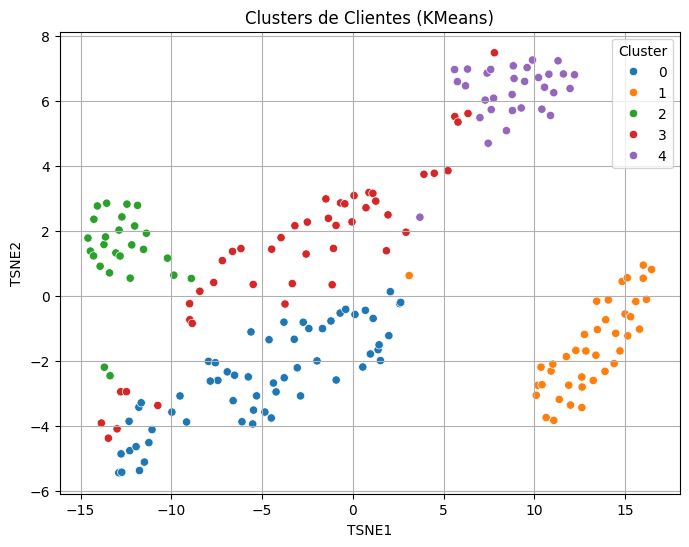

In [ ]:
visualizar_clusters(
    df=tsne_kmeans,
    columna_x='TSNE1',
    columna_y='TSNE2',
    columna_hue='Cluster_KMeans'
)

In [ ]:
cluster_summary = df_encoded.groupby(['Cluster_KMeans'])[['Age', 'Annual Income (k$)', 'Spending Score (1-100)','Genre']].describe().T
cluster_summary

Cluster_KMeans                        0           1          2          3  \
Age                    count  58.000000   40.000000  26.000000  45.000000   
                       mean   55.275862   32.875000  25.769231  26.733333   
                       std     8.571256    3.857643   5.435496   7.085196   
                       min    40.000000   27.000000  18.000000  18.000000   
                       25%    49.000000   30.000000  21.250000  20.000000   
                       50%    53.000000   32.000000  24.000000  26.000000   
                       75%    63.750000   36.000000  30.750000  32.000000   
                       max    70.000000   40.000000  35.000000  40.000000   
Annual Income (k$)     count  58.000000   40.000000  26.000000  45.000000   
                       mean   47.620690   86.100000  26.115385  54.311111   
                       std    13.413567   16.339036   8.557228  16.162277   
                       min    19.000000   69.000000  15.000000  16.000000   
                       25%    39.250000   74.750000  19.000000  46.000000   
                       50%    48.500000   78.500000  24.500000  59.000000   
                       75%    59.750000   94.000000  33.000000  64.000000   
                       max    67.000000  137.000000  42.000000  81.000000   
Spending Score (1-100) count  58.000000   40.000000  26.000000  45.000000   
                       mean   41.706897   81.525000  74.846154  40.911111   
                       std    15.697814    9.999968  15.069684  16.285552   
                       min     3.000000   58.000000  39.000000   5.000000   
                       25%    37.250000   74.000000  67.500000  35.000000   
                       50%    46.000000   83.000000  75.500000  46.000000   
                       75%    52.000000   90.000000  81.750000  54.000000   
                       max    60.000000   97.000000  99.000000  60.000000   
Genre                  count  58.000000   40.000000  26.000000  45.000000   
                       mean    0.568966    0.550000   0.576923   0.600000   
                       std     0.499546    0.503831   0.503831   0.495434   
                       min     0.000000    0.000000   0.000000   0.000000   
                       25%     0.000000    0.000000   0.000000   0.000000   
                       50%     1.000000    1.000000   1.000000   1.000000   
                       75%     1.000000    1.000000   1.000000   1.000000   
                       max     1.000000    1.000000   1.000000   1.000000   

Cluster_KMeans                         4  
Age                    count   31.000000  
                       mean    44.387097  
                       std      8.232770  
                       min     32.000000  
                       25%     37.000000  
                       50%     44.000000  
                       75%     49.000000  
                       max     59.000000  
Annual Income (k$)     count   31.000000  
                       mean    89.774194  
                       std     16.754521  
                       min     71.000000  
                       25%     78.000000  
                       50%     87.000000  
                       75%     98.500000  
                       max    137.000000  
Spending Score (1-100) count   31.000000  
                       mean    18.483871  
                       std     10.194348  
                       min      1.000000  
                       25%     12.000000  
                       50%     17.000000  
                       75%     25.000000  
                       max     39.000000  
Genre                  count   31.000000  
                       mean     0.483871  
                       std      0.508001  
                       min      0.000000  
                       25%      0.000000  
                       50%      0.000000  
                       75%      1.000000  
                       max      1.000000

## Cluster jerarquico

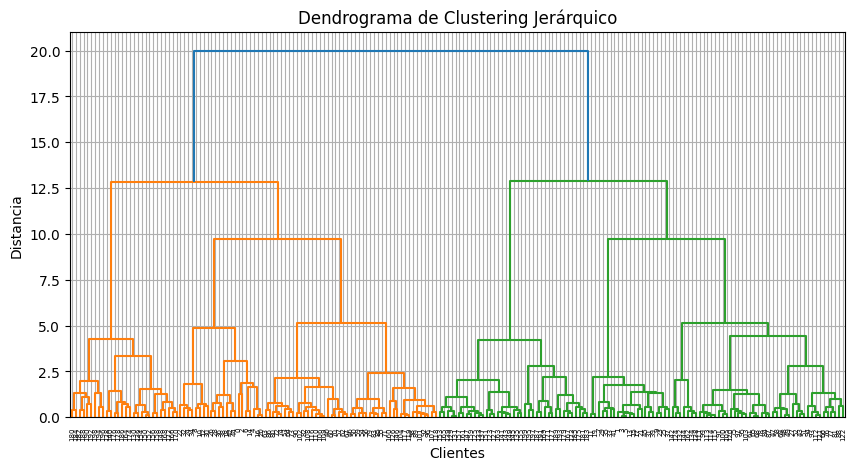

In [ ]:
linked = linkage(X_scaled, method='ward')
plt.figure(figsize=(10, 5))
dendrogram(linked, p=10)
plt.title("Dendrograma de Clustering Jerárquico")
plt.xlabel("Clientes")
plt.ylabel("Distancia")
plt.grid(True)
plt.show()

In [ ]:
# Cortamos el dendrograma en 5 clusters
df_encoded['Cluster_Hierarchical'] = fcluster(linked, 5, criterion='maxclust')

In [ ]:
pca_hir, tsne_hir = aplicar_pca_tsne(df_encoded, 'Cluster_Hierarchical', True)

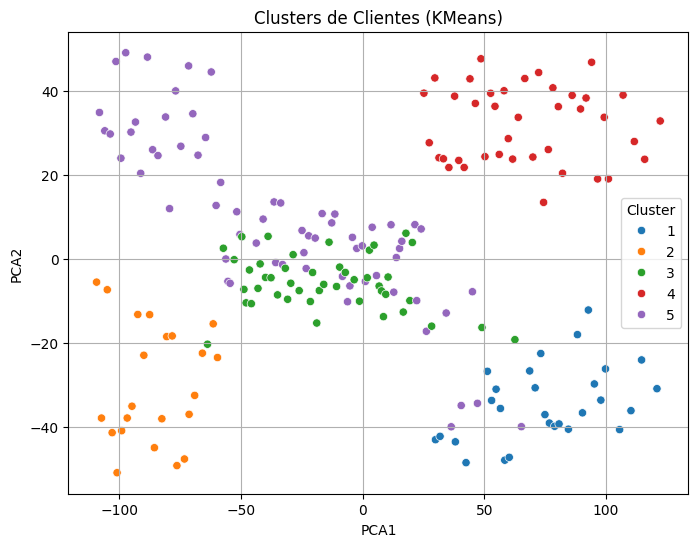

In [ ]:
visualizar_clusters(
    df=pca_hir,
    columna_x='PCA1',
    columna_y='PCA2',
    columna_hue='Cluster_Hierarchical'
)

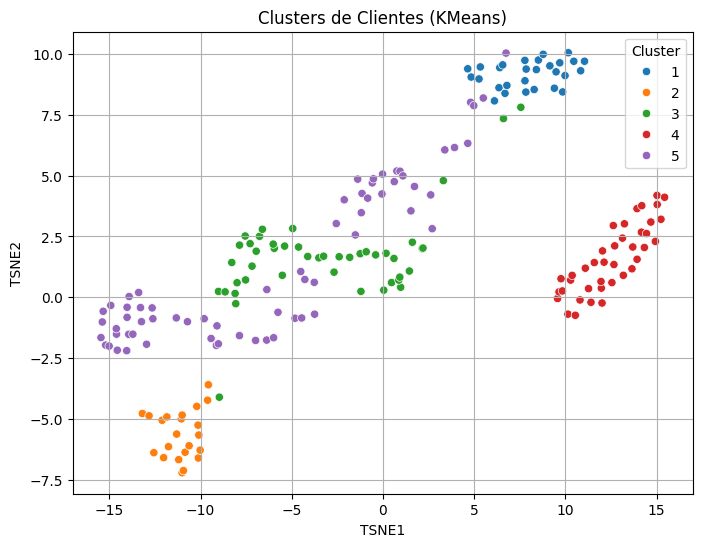

In [ ]:
visualizar_clusters(
    df=tsne_hir,
    columna_x='TSNE1',
    columna_y='TSNE2',
    columna_hue='Cluster_Hierarchical'
)

In [ ]:
cluster_summary = df_encoded.groupby(['Cluster_Hierarchical'])[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].describe().T
cluster_summary

Cluster_Hierarchical                   1          2          3           4  \
Age                    count   28.000000  22.000000  45.000000   39.000000   
                       mean    43.892857  44.318182  56.400000   32.692308   
                       std      8.337063  12.800247   8.373117    3.728650   
                       min     32.000000  19.000000  43.000000   27.000000   
                       25%     36.750000  35.250000  49.000000   30.000000   
                       50%     43.500000  45.500000  54.000000   32.000000   
                       75%     47.750000  52.750000  65.000000   35.500000   
                       max     59.000000  67.000000  70.000000   40.000000   
Annual Income (k$)     count   28.000000  22.000000  45.000000   39.000000   
                       mean    91.285714  25.772727  55.288889   86.538462   
                       std     16.915601   7.646548   9.834129   16.312485   
                       min     71.000000  15.000000  38.000000   69.000000   
                       25%     78.000000  19.250000  47.000000   75.500000   
                       50%     87.000000  24.500000  54.000000   79.000000   
                       75%     99.500000  32.250000  63.000000   95.000000   
                       max    137.000000  39.000000  79.000000  137.000000   
Spending Score (1-100) count   28.000000  22.000000  45.000000   39.000000   
                       mean    16.678571  20.272727  48.355556   82.128205   
                       std      8.973432  12.947446   6.869417    9.364489   
                       min      1.000000   3.000000  35.000000   63.000000   
                       25%     10.750000   7.750000  43.000000   74.500000   
                       50%     16.000000  16.000000  48.000000   83.000000   
                       75%     22.250000  31.750000  55.000000   90.000000   
                       max     39.000000  40.000000  60.000000   97.000000   

Cluster_Hierarchical                  5  
Age                    count  66.000000  
                       mean   26.560606  
                       std     7.043008  
                       min    18.000000  
                       25%    21.000000  
                       50%    24.500000  
                       75%    31.000000  
                       max    45.000000  
Annual Income (k$)     count  66.000000  
                       mean   47.363636  
                       std    18.328319  
                       min    15.000000  
                       25%    33.000000  
                       50%    48.000000  
                       75%    62.000000  
                       max    81.000000  
Spending Score (1-100) count  66.000000  
                       mean   56.787879  
                       std    20.628222  
                       min     5.000000  
                       25%    46.250000  
                       50%    55.000000  
                       75%    73.000000  
                       max    99.000000